<a href="https://colab.research.google.com/github/somilasthana/deeplearningtutorial/blob/master/Celeb_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import os
import hashlib
from urllib import request
import zipfile
import gzip
import shutil

import numpy as np
from PIL import Image
from tqdm import tqdm

%matplotlib inline
from glob import glob
from matplotlib import pyplot

import tensorflow as tf

In [0]:
def download_extract(data_path):
  url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip'
  hash_code = '00d2c5bc6d35e252742224ab0c1e8fcb'
  extract_path = os.path.join(data_path, 'img_align_celeba')
  save_path = os.path.join(data_path, 'celeba.zip')
  
  def _unzip(save_path, _):
    print("Extracting {}...")
    with zipfile.ZipFile(save_path) as zf:
      zf.extractall(data_path)
      
  if os.path.exists(extract_path):
    print("Data Found at {}".format(data_path))
  else:
    os.makedirs(extract_path)
    
  if not os.path.exists(data_path):
    os.makedirs(data_path)
    
  if not os.path.exists(save_path):
    request.urlretrieve(url, save_path)
    
  _unzip(save_path, extract_path)
  os.remove(save_path)

In [3]:
data_dir = './input'
download_extract(data_dir)

Extracting {}...


In [0]:
!ls -R ./input

In [0]:
def get_image(image_path, width, height, mode):
  image = Image.open(image_path)
  
  if image.size != (width, height):
    face_width = face_height = 108
    
    j = (image.size[0] - face_width) // 2
    i = (image.size[1] - face_height) // 2
    image = image.crop([j, i, j + face_width, i + face_height])
    image = image.resize([width, height], Image.BILINEAR)
    
  return np.array(image.convert(mode))

In [0]:
def get_batch(image_files, width, height, mode):
  
  data_batch = np.array(
      
      [
          get_image(sample_file, width, height, mode) for sample_file in image_files
      ]
  
  ).astype(np.float32)
  return data_batch

In [0]:
def images_square_grid(images, mode):
    """
    Save images as a square grid
    :param images: Images to be used for the grid
    :param mode: The mode to use for images
    :return: Image of images in a square grid
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)

    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

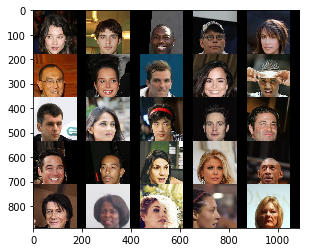

In [7]:
show_n_images = 25

celeb_images = get_batch(
    glob(
        os.path.join(
            data_dir, 'img_align_celeba/*.jpg')
    )[show_n_images:show_n_images+show_n_images], 
    178, 
    218, 
    'RGB'
)

pyplot.imshow(images_square_grid(celeb_images, 'RGB'))

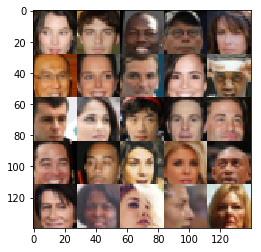

In [8]:
show_n_images = 25

celeb_images = get_batch(
    glob(
        os.path.join(
            data_dir, 'img_align_celeba/*.jpg')
    )[show_n_images:show_n_images+show_n_images], 
    28, 
    28, 
    'RGB'
)

pyplot.imshow(images_square_grid(celeb_images, 'RGB'))

In [9]:
import tensorflow as tf
print('Default gpu device {}'.format(tf.test.gpu_device_name()))

Default gpu device /device:GPU:0


In [0]:
def model_inputs(image_width, image_height, image_channel, z_dim):
  
  real_input_images = tf.placeholder(
      tf.float32,
      [None, image_width, image_height, image_channel], 
      'real_input_images'
  )
  
  input_z = tf.placeholder(
      tf.float32,
      [None, z_dim],
      'input_z'
  )
  
  learning_rate = tf.placeholder(tf.float32, [], 'learning_rate')
  
  return real_input_images, input_z, learning_rate

In [0]:
#Discriminator

In [0]:
def disriminator(images, reuse=False, alpha=0.2, keep_prob=0.5):
  
  with tf.variable_scope('discriminator', reuse=reuse):
    
    # Input layer is 28x28xn
    
    conv1 = tf.layers.conv2d(images, 64, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
    
    lrelu1 = tf.maximum(alpha * conv1, conv1)
    drop1 = tf.layers.dropout(lrelu1, keep_prob)
    
    # Strided convolutional layer, 7x7x128
    conv2 = tf.layers.conv2d(drop1, 128, 5, 2, 'same', use_bias=False)
    bn2 = tf.layers.batch_normalization(conv2)
    lrelu2 = tf.maximum(alpha * bn2, bn2)
    drop2 = tf.layers.dropout(lrelu2, keep_prob)
    
    # Strided convolutional layer, 4x4x256
    conv3 = tf.layers.conv2d(drop2, 256, 5, 2, 'same', use_bias=False)
    bn3 = tf.layers.batch_normalization(conv3)
    lrelu3 = tf.maximum(alpha *bn3, bn3)
    drop3 = tf.layers.dropout(lrelu3, keep_prob)
    
    # fully connected
    flat = tf.reshape(drop3, (-1, 4*4*256))
    logits = tf.layers.dense(flat, 1)
    out = tf.sigmoid(logits)
    
    return out, logits

In [0]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.5):
  
  with tf.variable_scope('generator', reuse=(not is_train)):
    # First fully connected layer, 4x4x1024
    fc = tf.layers.dense(z, 4*4*1024, use_bias=False)
    fc = tf.reshape(fc, (-1, 4, 4, 1024))
    bn0 = tf.layers.batch_normalization(fc, training=is_train)
    lrelu0 = tf.maximum(alpha * bn0, bn0)
    drop0 = tf.layers.dropout(lrelu0, keep_prob)
    
    # Deconvolution, 7x7x512
    conv1 = tf.layers.conv2d_transpose(drop0, 512, 4, 1, 'valid', use_bias=False)
    bn1 = tf.layers.batch_normalization(conv1, training=is_train)
    lrelu1 = tf.maximum(alpha * bn1, bn1)
    drop1 = tf.layers.dropout(lrelu1, keep_prob, training=is_train)
    
    # Deconvolution, 14x14x256
    conv2 = tf.layers.conv2d_transpose(drop1, 256, 5, 2, 'same', use_bias=False)
    bn2 = tf.layers.batch_normalization(conv2, training=is_train)
    lrelu2 = tf.maximum(alpha * bn2, bn2)
    drop2 = tf.layers.dropout(lrelu2, keep_prob, training=is_train)
    
    # Output layer , 28 X 28 X n
    logits = tf.layers.conv2d_transpose(drop2, out_channel_dim, 5, 2, 'same')
    
    out = tf.tanh(logits)
    
    return out
    
    

In [0]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth_factor=0.1):
  
  d_model_real, d_logits_real = disriminator(input_real, reuse=tf.AUTO_REUSE, alpha=alpha)
  
  d_loss_real = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1-smooth_factor))
  )
  
  input_fake = generator(input_z, out_channel_dim, alpha=alpha)
  d_model_fake, d_logits_fake = disriminator(input_fake, reuse=tf.AUTO_REUSE, alpha=alpha)
  
  d_loss_fake = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_fake, labels=tf.zeros_like(d_logits_fake))
  )
  
  g_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_fake, labels=tf.ones_like(d_logits_fake))
  )
  
  return d_loss_real + d_loss_fake, g_loss

In [0]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
  
  t_vars = tf.trainable_variables()
  d_vars = [ var for var in t_vars if var.name.startswith('discriminator')]
  g_vars = [ var for var in t_vars if var.name.startswith('generator')]
  
  with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
  return d_train_opt, g_train_opt

In [0]:
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
  
  cmap = None if image_mode == 'RGB' else 'gray'
  
  z_dim = input_z.get_shape().as_list()[-1]
  
  example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
  
  samples = sess.run(generator(input_z, out_channel_dim, False),
                     feed_dict={input_z: example_z}
  )
  
  images_grid = images_square_grid(samples, image_mode)
  
  return images_grid

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
  
  image_width, image_height, image_channel = data_shape[1], data_shape[2], data_shape[3]
  
  input_real, input_z , _ = model_inputs(image_width, image_height, image_channel, z_dim)
  
  d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
  
  d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
  
  saver = tf.train.Saver()
  
  sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
  
  samples, losses = [], []
  
  steps = 0
  count = 0
  
  with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    
    save_path = saver.save(sess, "/tmp/model.ckpt")
    ckpt = tf.train.latest_checkpoint('./model/')
    
    saver.restore(sess, save_path)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    os.mkdir('output')
    
    for epoch_i in range(epoch_count):
      os.mkdir('output/'+str(epoch_i))
      
      for batch_images in get_batches(batch_size):
        steps += 1
        batch_images *= 2.0
        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
        
        sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
        sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        if steps % print_every == 0:
          
          train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
          train_loss_g = g_loss.eval({input_z: batch_z})
          
          print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, steps),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
          
          losses.append((train_loss_d, train_loss_g))
          
        if steps % show_every == 0:
          
          count +=1
          iterr = count*show_every
          
          image_grid = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
          dst = os.path.join("output", str(epoch_i), str(iterr)+".png")
          pyplot.imsave(dst, image_grid)
          
        if epoch_i % 10:
          if not os.path.exists('./model/'):
            os.makedirs('./model')
            saver.save(sess, './model/' + str(epoch_i))

In [0]:
batch_size = 64
z_dim = 100
learning_rate = 0.00025
beta1 = 0.45

epochs=100

In [0]:
class Dataset:
  
  def __init__(self, data_files, image_mode, image_channels):
    
    IMAGE_WIDTH = 28
    IMAGE_HEIGHT = 28
    
    self.image_mode = image_mode
    self.image_channels = image_channels
    
    self.data_files = data_files
    self.shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels
    
  def get_batches(self, batch_size):
    IMAGE_MAX_VALUE = 255
    
    current_index = 0
    
    while current_index + batch_size <= self.shape[0]:
      data_batch = get_batch(
          self.data_files[current_index: current_index + batch_size],
          *self.shape[1:3],
          self.image_mode
      )
      
      current_index += batch_size
      
      yield data_batch / IMAGE_MAX_VALUE- 0.5
    
    

In [0]:
celeb_dataset = Dataset(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')), image_mode='RGB', image_channels=3)



In [0]:
with tf.Graph().as_default():
  train(epochs, batch_size, z_dim, learning_rate, beta1, celeb_dataset.get_batches, celeb_dataset.shape, celeb_dataset.image_mode)

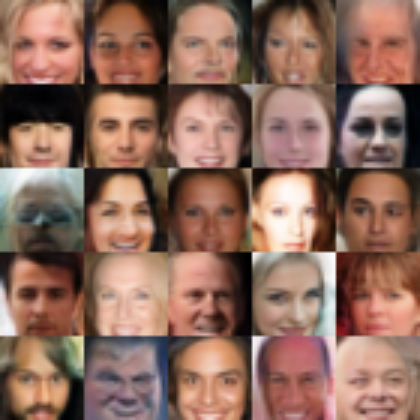

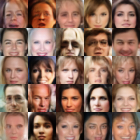

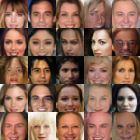

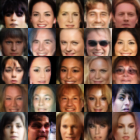

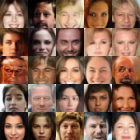

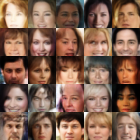

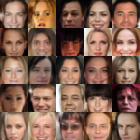

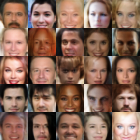

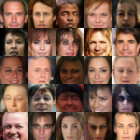

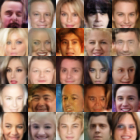

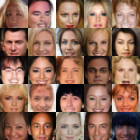

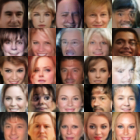

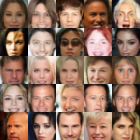

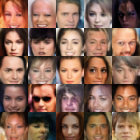

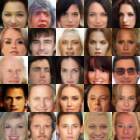

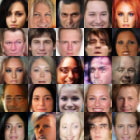

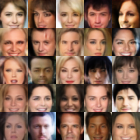

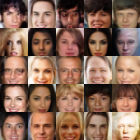

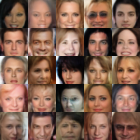

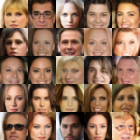

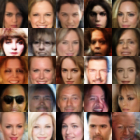

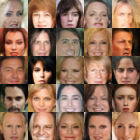

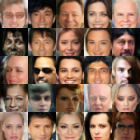

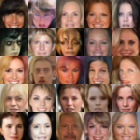

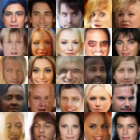

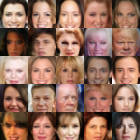

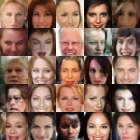

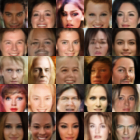

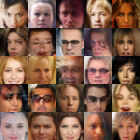

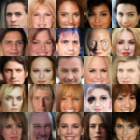

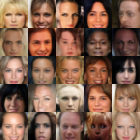

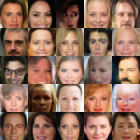

In [28]:
import cv2
import glob
from google.colab.patches import cv2_imshow
for f in glob.glob("output/9/*.png"):
    image = cv2.imread(f)
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    large = cv2.resize(image, (0,0), fx=3, fy=3)
    cv2.imwrite(f, large)